# Multi-Level Models (Hierarchical Models)

So far, we haven't considered the probability distribution of the fitting parameters $D_0,k_1,k_2$, and $k_3$. But to use a hierarchical model to combine our inference from different patch data and allow us to model our serum estradiol concentration, we will need to introduce hyperparameters that connect different studies. This way, our fitting parameters are given a "probabilistic specification" in terms of hyperparameters that are common for all. In our case, the hyperparameters would be the parameters of the distribution ([hyperprior](https://en.wikipedia.org/wiki/Hyperprior)) we choose to use in order to model our fitting parameters.

# Before and After Patch Removal

We can see from [3_Steady-State_Multi-Dose_3-Compartment](3_Steady-State_Multi-Dose_3-Compartment) that the decay after patch removal is not captured when the serum Estradiol solution didn't consider measurement after patch removal as a separate process.

After patch removal, the estradiol concentration within the depot $d_0$ (and thus $D(t_0)$) is zero.

We then [evolve](https://discord.com/channels/438306949285806082/1201973466845151362/1206123175331627029) our solution $E_2(t)$ with the initial condition at patch removal $t_{\rm rem}$ to be given by $A_{\rm eff}(t_{\rm rem})$ and $E_2(t_{\rm rem})$. i.e., we have for $E_2(t)$ after $t_{\rm rem}$

$$E_2^{t_{\rm rem}}(t)=\frac{k_2A_{\rm eff}(t_{\rm rem})}{k_2-k_3}\left[-\frac{e^{-k_2(t-T\operatorname{floor}(t/T))}}{1-e^{-k_2T}}+\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}\right]+E_2(t_{\rm rem})\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}},$$ where $A_{\rm eff}(t_{\rm rem})$ and $E_2(t_{\rm rem})$ [follows](https://discord.com/channels/438306949285806082/1201973466845151362/1209322177988661348) from the time-evolution of $\frac{\operatorname{d}A_{\rm eff}}{\operatorname{d}t}$ and $\frac{\operatorname{d}E_2}{\operatorname{d}t}$, respectively. [With the solutions](https://discord.com/channels/438306949285806082/1201973466845151362/1209294410731487255) to these two DEs given in [2_Multi-Dose_3-Compartment](2_Multi-Dose_3-Compartment.ipynb) (for a single-dose model):
\begin{align*}
    A_{\rm eff}(t_{\rm rem})&=\frac{k_1D(t_0)}{k_1-k_2}\left[-e^{-k_1t}+e^{-k_2t}\right],\\
    E_2^{\rm after}(t_{\rm rem})&=E_2^{\rm before}(t_{\rm rem}).
\end{align*}

# First Encounter with PyMC

We will start by fitting the data to our previous model (without taking patch removal into account) using PyMC. PyMC defaults to Hamiltonian Monte Carlo using the [No-U-Turn (NUTS) sampler](https://arxiv.org/abs/1111.4246) that avoids random walks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import jax
jax.default_backend()

'gpu'

In [3]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

# exclude n = 30 study from H2003b due to the initial measurement being higher than the second measurement
#H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

The solution to the 3-compartment model is given by (from [2_Multi-Dose_3-Compartment](2_Multi-Dose_3-Compartment))

\begin{align*}
    E_2(t)&=k_1k_2\sum_{i=1}^nD_iH(t-t_i)\left[\frac{e^{-k_1(t-t_i)}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2(t-t_i)}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3(t-t_i)}}{(k_1-k_3)(k_2-k_3)}\right]\\
    &~~~~+\frac{k_2}{k_2-k_3}\sum_{j=1}^nA_{\rm eff,j}H(t-t_j)\left[-e^{-k_2(t-t_j)}+e^{-k_3(t-t_j)}\right]+\sum_{l=1}^nE_{2l}H(t-t_l)e^{-k_3(t-t_l)}.
\end{align*}

Assuming a single dose, then we have the following [after taking patch removal at $t_{\rm rem}$ into considertion](https://discord.com/channels/438306949285806082/1201973466845151362/1209715615615553576):

\begin{align*}
    E_2(t)&=k_1k_2D_i\left[\frac{e^{-k_1t}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2t}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3t}}{(k_1-k_3)(k_2-k_3)}\right]\\
    &~~~~+\frac{A_{\rm eff,j}k_2}{k_2-k_3}\left[-e^{-k_2(t-t_{\rm rem})}+e^{-k_3(t-t_{\rm rem})}\right]+E_{2l}e^{-k_3(t-t_{\rm rem})},
\end{align*} where while the last two terms are evolving in time, they are [purely external](https://discord.com/channels/438306949285806082/1201973466845151362/1209727625694806057) since they are the "initial" conditions (see the solution to $\dot A_{\rm eff}(t)$ from [2_Multi-Dose_3-Compartment](2_Multi-Dose_3-Compartment), given below).

While $D_i$ is a fitting parameter, $A_{\rm eff,i}$ and $E_{2i}$ follow from the time evolution of $\frac{\operatorname{d}A_{\rm eff}}{\operatorname{dt}}$ and $\frac{\operatorname{d}E_2}{\operatorname{dt}}$ respectively, with the solution to $\frac{\operatorname{d}A_{\rm eff}}{\operatorname{dt}}$ given by $$A_{\rm eff}(t)=\frac{k_1}{k_1-k_2}\sum_{i=1}^n D_iH(t-t_i)\left[-e^{-k_1(t-t_i)}+e^{-k_2(t-t_i)}\right]+\sum_{j=1}^nA_{\rm eff,j}H(t-t_j)e^{-k_2(t-t_j)}.$$

For the single-dose case, we can rewrite $A_{\rm eff}(t)$ as $$A_{\rm eff}(t)=\frac{D_ik_1}{k_1-k_2}\left[-e^{-k_1t}+e^{-k_2t}\right]+A_{\rm eff,j}e^{-k_2t}.$$

In [4]:
def E2(t, d0, k1, k2, k3):
    summation = 0
    innerFunc1 = pm.math.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = pm.math.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = pm.math.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summation = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summation

# steady-state solution, A_{\rm eff}(t_0) = 0 and E_2(t_0) = 0
def E2ss(t, D0, k1, k2, k3, T):
    innerFunc1 = np.exp(-k1 * (t - T * np.floor(t/T))) / ((1 - np.exp(-k1*T)) * (k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * (t - T * np.floor(t/T))) / ((1 - np.exp(-k2*T)) * (k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * (t - T * np.floor(t/T))) / ((1 - np.exp(-k3*T)) * (k1 - k3) * (k2 - k3))
    return k1 * k2 * D0 * (innerFunc1 - innerFunc2 + innerFunc3)

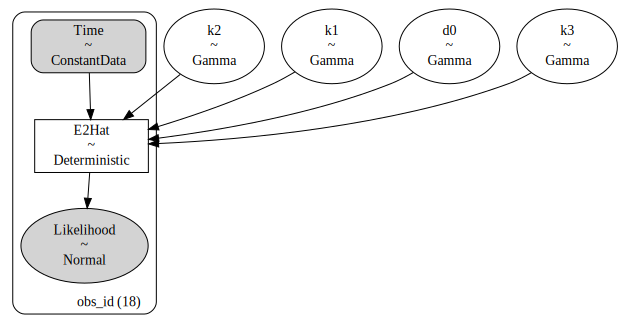

In [5]:
# https://github.com/obscode/FlyingCircus/blob/master/MoreNotebooks/ModelFitting/Pymc.ipynb
# https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#deterministic-transforms

# LaTeX needs to be treated as raw string literal for az to work, https://lightrun.com/answers/arviz-devs-arviz-latex-label-compatibility-issues-while-using-bokeh-as-backend, https://stackoverflow.com/questions/2081640/what-exactly-do-u-and-r-string-prefixes-do-and-what-are-raw-string-literals
# better not use LaTeX for variable names due to issues with plotting via az.plot_ppc

# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/multilevel_modeling.ipynb

Mylan100Model = pm.Model()

with Mylan100Model:
    # import data, https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.get_data.html
    Mylan100TimeData = pm.ConstantData("Time", MylanTDP100[:,0], dims="obs_id")
    #Mylan100Data = pm.ConstantData("E2Observed", MylanTDP100[:,1], dims="obs_id")
    sigma = pm.math.sqrt(MylanTDP100[:,1])    # Standard deviation

    # priors
    # https://discord.com/channels/438306949285806082/1201973466845151362/1207590977334812782:
    # log normal should technically work, but it's kind of a strange choice unless you're using it as the error model on data-points, which I've been using for one of the patch fit incidentally.
    # when 0 < alpha < 1 you get an interesting diverging behavior close to 0. You can use that for example to mimick the effect of an improper logarithmic prior 1/x while keeping everything proper ...
    # ... but in the end as long as the domain of the prior is sound and it's sufficiently "diffuse" over the realistic ...
    # ... range of the parameter in question then the effect of the prior will be suppressed by the information in the data.
    d0 = pm.Gamma("d0", alpha=100, beta=0.5)    # https://www.geogebra.org/m/rz3vkzf5, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462
    #Aeff0 = pm.Gamma("Aeff0", alpha=1, beta=50)
    #E20 = pm.Gamma("E20", alpha=1, beta=100)
    k1 = pm.Gamma("k1", alpha=1/(100/24), beta=4)    # https://www.desmos.com/calculator/vk2tqrxpk5
    k2 = pm.Gamma("k2", alpha=0.15, beta=4)    # based on previous fits
    k3 = pm.Gamma("k3", alpha=1/37, beta=4)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html

    # likelihood, https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html
    # https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
    E2Hat = pm.Deterministic("E2Hat", E2(Mylan100TimeData, d0, k1, k2, k3), dims="obs_id")
    # https://discord.com/channels/438306949285806082/1201973466845151362/1207878490360250398:
    # The likelihood function can be a lognormal but you have to be careful not to feed it 0 values unless you add a (random) baseline first, so like x[i] ~ LogNorma(log(E2(ti) + b), sigma)
    Likelihood = pm.Normal("Likelihood", mu = E2Hat, observed = MylanTDP100[:,1],
                              sigma=sigma, dims="obs_id")

# visualize the model
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
pm.model_to_graphviz(Mylan100Model)

#Mylan100Model.free_RVs

In [6]:
Mylan100Model

        d0 ~ Gamma(100, f())
        k1 ~ Gamma(0.24, f())
        k2 ~ Gamma(0.15, f())
        k3 ~ Gamma(0.027, f())
     E2Hat ~ Deterministic(f(d0, k2, k1, k3))
Likelihood ~ Normal(E2Hat, f())

In [7]:
# obtain Maximum A-Posteriori
with Mylan100Model:
    sampleMylan100 = pm.sample(15000, tune=1000)

az.summary(sampleMylan100, var_names = ["d0", "k1", "k2", "k3"], kind="stats")    # see https://python.arviz.org/en/latest/api/diagnostics.html

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d0, k1, k2, k3]
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 79 seconds.


,mean,sd,hdi_3%,hdi_97%
d0,219.908,15.842,190.435,249.595
k1,0.192,0.107,0.059,0.382
k2,0.182,0.105,0.060,0.373
k3,0.036,0.002,0.031,0.040


In [8]:
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Mylan100Model:
    pm.sample_posterior_predictive(sampleMylan100, extend_inferencedata=True, random_seed=rng)

sampleMylan100

Sampling: [Likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


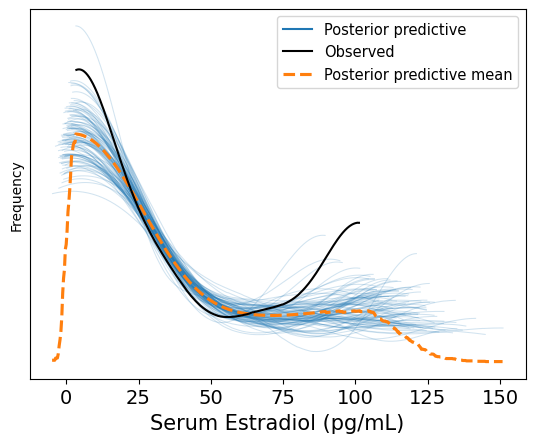

In [9]:
# labeling the plot, https://python.arviz.org/en/stable/api/generated/arviz.plot_ppc.html
# https://python.arviz.org/en/stable/user_guide/label_guide.html#label-guide
# y-axis below is frequency, see https://rlhick.people.wm.edu/stories/bayesian_7.html
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map={"Likelihood": r"Serum Estradiol (pg/mL)"})
az.plot_ppc(sampleMylan100, num_pp_samples=100, var_names="Likelihood", labeller=labeller);
plt.ylabel('Frequency')
plt.show()

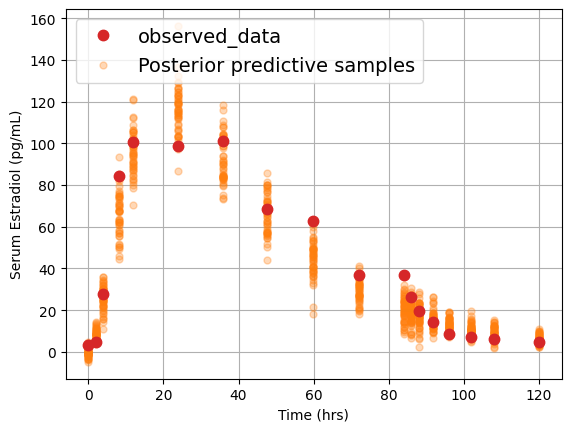

In [10]:
az.plot_lm(idata=sampleMylan100, y="Likelihood", x=MylanTDP100[:,0])
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.show()

In [11]:
# extract predicted serum Estradiol, https://python.arviz.org/en/stable/api/generated/arviz.r2_score.html

Mylan100Hat = sampleMylan100.posterior_predictive.stack(sample=("chain", "draw"))["Likelihood"].values.T
Mylan100Hat

array([[-2.2184651 , 10.65586644, 29.5271685 , ...,  7.75943706,
        10.96891585,  6.62374842],
       [ 1.99972811,  8.70769882, 33.91610004, ..., 11.190083  ,
         8.63367368,  8.63357187],
       [-0.64360503,  7.57988677, 32.0139355 , ..., 17.23827825,
        14.80088707,  4.87019939],
       ...,
       [ 0.20993201,  6.16162247, 29.01154559, ...,  9.29534399,
         8.9884848 ,  4.99554271],
       [ 1.1646462 ,  7.38693467, 27.24074329, ..., 10.58417486,
         7.12057151,  7.25967163],
       [-1.87530904,  8.95578254, 25.23508132, ..., 12.27728412,
        10.01140836,  5.72890929]])

In [12]:
# check r^2, r^2=1 => prefect fit
az.r2_score(MylanTDP100[:,1], Mylan100Hat)

r2        0.916925
r2_std    0.026171
dtype: float64

In [13]:
# obtain Maximum A-Posteriori, https://discord.com/channels/438306949285806082/1201973466845151362/1202106780339937310
# https://discourse.pymc.io/t/what-makes-difference-find-map-and-pm-sample/8182
with Mylan100Model:
    Mylan100MAP = pm.find_MAP()
Mylan100MAP

{'d0_log__': array(5.39098262),
 'k1_log__': array(-1.30299361),
 'k2_log__': array(-2.38052035),
 'k3_log__': array(-3.34311031),
 'd0': array(219.41888486),
 'k1': array(0.27171716),
 'k2': array(0.09250243),
 'k3': array(0.03532691),
 'E2Hat': array([-7.83726293e-14,  8.31441380e+00,  2.59315981e+01,  6.68014986e+01,
         9.45133435e+01,  1.16565723e+02,  9.55923810e+01,  6.92363267e+01,
         4.71286013e+01,  3.11918662e+01,  2.07390017e+01,  1.93633870e+01,
         1.80767435e+01,  1.58132181e+01,  1.36606589e+01,  1.11426353e+01,
         8.93743748e+00,  5.86327819e+00])}

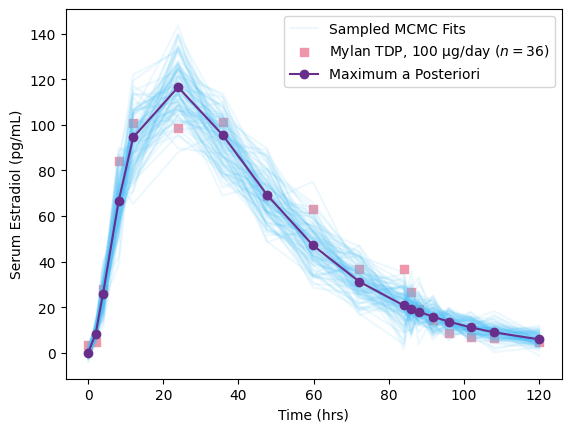

In [14]:
inds = np.random.randint(len(Mylan100Hat), size=100)

for ind in inds:
    plt.plot(MylanTDP100[:,0], Mylan100Hat[ind], alpha=0.1, color='#4EC2F8')
plt.plot(MylanTDP100[:,0], Mylan100Hat[50000], alpha=0.1, color='#4EC2F8', label='Sampled MCMC Fits')
plt.scatter(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
plt.plot(MylanTDP100[:,0], Mylan100MAP['E2Hat'], label='Maximum a Posteriori', color='#672F8B', marker='o')
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

The results from Hamiltonian Monte Carlo (HMC) looks rather similar to what we got from using the affine invariant MCMC (`emcee`), even though with the `lmfit` wrapper of `emcee`, we were only setting the prior with essentially [uniform](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Uniform.html) distributions.

## Compare with MLE

In [15]:
def E2np(t, d0, k1, k2, k3):
    summation = 0
    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summation = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summation

import lmfit
# setting up model using lmfit
Mylan100Model = lmfit.Model(E2np)

Mylan100Params = Mylan100Model.make_params(d0=dict(value=100,min=0,max=250),
                                           k1=dict(value=1/(100/24),min=0.1,max=0.5),
                                           k2=dict(value=2,min=0,max=10),
                                           k3=dict(value=1/37,min=0.01,max=0.1))

emcee_kws = dict(steps=10000, burn=500, thin=20, is_weighted=False)

result_emcee = Mylan100Model.fit(data=MylanTDP100[:,1], t=MylanTDP100[:,0],
                                 params=Mylan100Params, method='emcee',
                                 nan_policy='omit', fit_kws=emcee_kws)

100%|██████████| 10000/10000 [01:40<00:00, 99.97it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [207.69710651 389.47984814 315.80982431 199.89479643 257.82779956]


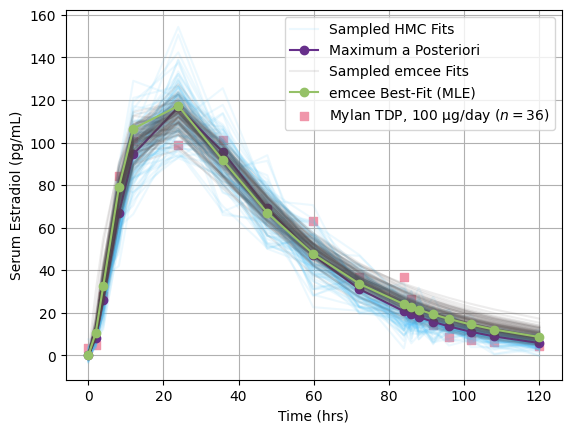

In [16]:
# plot and compare the outputs of the two samplers used (PyMC and emcee)

inds = np.random.randint(len(Mylan100Hat), size=100)
indss = np.random.randint(len(result_emcee.flatchain), size=100)

for ind in inds:
    plt.plot(MylanTDP100[:,0], Mylan100Hat[ind], alpha=0.1, color='#4EC2F8')
plt.plot(MylanTDP100[:,0], Mylan100Hat[50000], alpha=0.1, color='#4EC2F8', label='Sampled HMC Fits')
plt.plot(MylanTDP100[:,0], Mylan100MAP['E2Hat'], label='Maximum a Posteriori', color='#672F8B', marker='o')

for ind in indss:
    sample = (result_emcee.flatchain["d0"][ind], result_emcee.flatchain["k1"][ind],
              result_emcee.flatchain["k2"][ind], result_emcee.flatchain["k3"][ind])
    plt.plot(MylanTDP100[:,0], E2np(MylanTDP100[:,0], sample[0], sample[1], sample[2], sample[3]), alpha=0.1, color='#544a49')
plt.plot(MylanTDP100[:,0], E2np(MylanTDP100[:,0], sample[0], sample[1], sample[2], sample[3]), alpha=0.1, color='#544a49', label='Sampled emcee Fits')
plt.plot(MylanTDP100[:,0], result_emcee.best_fit, label='emcee Best-Fit (MLE)', color='#95c167', marker='o')

plt.scatter(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
plt.grid(visible=True)
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

Maximum likelihood estimation and maximum a Posteriori estimation from these two different Monte Carlo samplers appear to be similar.

# The Explicit Case of Patch Removal (PyMC)

In [73]:
# fitting using single-dose model
# improved, now take patch removal into account, assume removal time t_{\rm rem} = 3.5 days
# pymc builds on pyTensor, so need tensor maths, https://stackoverflow.com/questions/73049218/must-be-real-number-not-tensorvariable
# https://www.pymc.io/projects/docs/en/stable/api/math.html: Doing any kind of math with PyMC random variables, ...
# ... or defining custom likelihoods or priors requires you to use these PyTensor expressions rather than NumPy or Python code.

# D(t) dose term
def E2DoseTerm(t, d0, k1, k2, k3):
    summationDose = 0
    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summationDose = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summationDose

# A_{\rm eff}(t) term, only for t > t_rem since...
# ... A_{\rm eff}(t_0) = E2(t_0) = 0 for t <= t_rem
def AEffTerm(t, AeffEvolution, k2, k3):
    summationEff = 0
    innerFunc1Eff = np.exp(-k2 * t)
    innerFunc2Eff = np.exp(-k3 * t)
    summationEff = AeffEvolution * (-innerFunc1Eff + innerFunc2Eff)
    return k2 * summationEff / (k2 - k3)

# serum E2(t) term, only for t > t_rem
def E2Term(t, E2Evolution, k3):
    return E2Evolution * np.exp(-k3 * t)

# serum estradiol full solution, taking patch removal at t_rem into account
# heaviside in place of if-elseif, https://stackoverflow.com/a/76055908
def E2Full(t, d0, AeffEvolution, E2Evolution, k1, k2, k3):
    #return E2DoseTerm(t, d0, k1, k2, k3) * (1 - np.heaviside(t-t_rem, 0)) + (AEffTerm(t, Aeff_trem, k2, k3) + E2Term(t, E2_trem, k3)) * np.heaviside(t-t_rem, 0)
    return E2DoseTerm(t, d0, k1, k2, k3) + AEffTerm(t, AeffEvolution, k2, k3) + E2Term(t, E2Evolution, k3)

# vectorize the above function to allow multidimensional arrays as input, https://discord.com/channels/438306949285806082/1201973466845151362/1209300959117705266
# not really needed
#E2FullVec = np.vectorize(E2Full, otypes=[float])

In [32]:
# time evolution of A_{\rm eff}(t) and E_2(t) (for t>0, with A_{\rm eff}(t=0)=E_2(t=0)=0) ...
# ... follows from the solution of dA_{\rm eff}/dt and dE_2/dt

def AEffEvolution(t, d0, k1, k2):
    return d0 * k1 * (-np.exp(-k1 * t) + np.exp(-k2 * t)) / (k1 - k2)

#AEffAtRemovalVec = np.vectorize(AEffAtRemoval, otypes=[float])

def E2Evolution(t, d0, k1, k2, k3):
    return E2DoseTerm(t, d0, k1, k2, k3) * np.exp(-k3 * t)

#E2AtRemovalVec = np.vectorize(E2AtRemoval, otypes=[float])

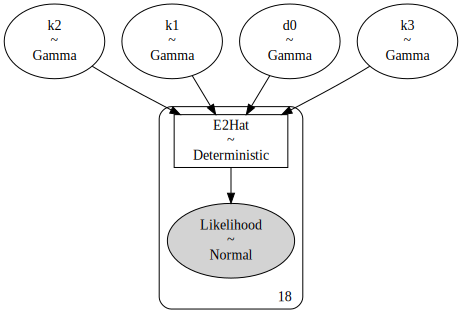

In [33]:
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/multilevel_modeling.ipynb
# the matrix exponential approach is really pretty and seamless for stitching different equations together and would work wonders in a multi-ROA/multi-model context... https://discord.com/channels/438306949285806082/1201973466845151362/1202269011497451540

with pm.Model() as Mylan100PatchRemoval:
    # import data, https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.get_data.html
    # not doing this to avoid the need to write vectorized functions, https://discord.com/channels/438306949285806082/1201973466845151362/1209319299227983882
    #Mylan100TimeData = pm.ConstantData("Time", MylanTDP100[0:11,0], dims="obs")

    #Mylan100Data = pm.ConstantData("E2Observed", MylanTDP100[:,1], dims="obs_id")
    sigma = pm.math.sqrt(MylanTDP100[:,1])    # Standard deviation

    # set patch removal time, add 1 to avoid floating point error
    t_rem = MylanTDP100[0:11,0][10]+1

    ### priors on fitting parameters ###
    # need to fit d0
    d0 = pm.Gamma("d0", alpha=100, beta=0.5)    # https://www.geogebra.org/m/rz3vkzf5, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462

    # we shouldn't fit Aeff0 and E20, https://discord.com/channels/438306949285806082/1201973466845151362/1209294410731487255
    # rather depends on d0, k1, and k2

    # the initial conditions Aeff0 and E20 depend on k1, https://discord.com/channels/438306949285806082/1201973466845151362/1209306363440930927
    k1 = pm.Gamma("k1", alpha=1/(100/24), beta=4)    # https://www.desmos.com/calculator/vk2tqrxpk5
    k2 = pm.Gamma("k2", alpha=0.15, beta=4)    # based on previous fits
    k3 = pm.Gamma("k3", alpha=1/37, beta=4)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html
    ### end priors ###

    # initial conditions for after patch removal
    #AEffICAfter = pm.Deterministic("I.C. AEff(t_rem)", AEffAfterRemoval(MylanTDP100[:,0], d0, k1, k2))    # only need values after t_rem, using pm.math.switch below
    #E2ICAfter = pm.Deterministic("I.C. E2(t_rem)", E2AfterRemoval(MylanTDP100[:,0], d0, k1, k2, k3))

    # likelihood
    # switch: switch(t[i] < W, Normal(E2before(t[i]), sigma), Normal(E2after(t[i]), sigma)), https://discord.com/channels/438306949285806082/1201973466845151362/1209323159380168725
    E2Hat = pm.Deterministic("E2Hat", E2Full(MylanTDP100[:,0], pm.math.switch(MylanTDP100[:,0] < t_rem, d0, 0),
                                             AEffEvolution(MylanTDP100[:,0], d0, k1, k2),
                                             E2Evolution(MylanTDP100[:,0], d0, k1, k2, k3),
                                             k1, k2, k3))

    Likelihood = pm.Normal("Likelihood", mu = E2Hat, observed = MylanTDP100[:,1],
                           sigma=sigma)

# visualize the model
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
pm.model_to_graphviz(Mylan100PatchRemoval)

In [34]:
# running HMC
with Mylan100PatchRemoval:
    sampleMylan100Removal = pm.sample(15000, tune=1000)

az.summary(sampleMylan100Removal, var_names = ["d0", "k1", "k2", "k3"], kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d0, k1, k2, k3]
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 51 seconds.


,mean,sd,hdi_3%,hdi_97%
d0,239.682,21.144,199.836,279.003
k1,0.431,0.102,0.259,0.622
k2,0.019,0.002,0.015,0.023
k3,0.042,0.004,0.033,0.050


In [35]:
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Mylan100PatchRemoval:
    pm.sample_posterior_predictive(sampleMylan100Removal, extend_inferencedata=True, random_seed=rng)

sampleMylan100Removal

Sampling: [Likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [36]:
# extract predicted serum Estradiol, https://python.arviz.org/en/stable/api/generated/arviz.r2_score.html

Mylan100RemovalHat = sampleMylan100Removal.posterior_predictive.stack(sample=("chain", "draw"))["Likelihood"].values.T

# obtain Maximum A-Posteriori, https://discord.com/channels/438306949285806082/1201973466845151362/1202106780339937310
# https://discourse.pymc.io/t/what-makes-difference-find-map-and-pm-sample/8182
with Mylan100PatchRemoval:
    Mylan100RemovalMAP = pm.find_MAP()
Mylan100RemovalMAP

{'d0_log__': array(5.48090545),
 'k1_log__': array(-0.89576978),
 'k2_log__': array(-4.00152575),
 'k3_log__': array(-3.18653244),
 'd0': array(240.06397529),
 'k1': array(0.40829318),
 'k2': array(0.01828772),
 'k3': array(0.04131488),
 'E2Hat': array([5.09458441e-14, 9.26343275e+00, 2.55901129e+01, 5.58135166e+01,
        7.33973201e+01, 9.20811012e+01, 8.85118573e+01, 7.82041711e+01,
        6.59777863e+01, 5.42218627e+01, 4.42763738e+01, 7.43364366e+00,
        6.96141762e+00, 6.12337229e+00, 5.31737545e+00, 4.36273489e+00,
        3.51575159e+00, 2.31746555e+00])}

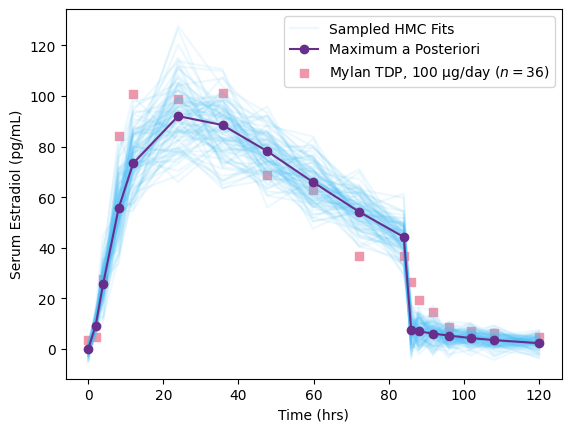

In [37]:
inds = np.random.randint(len(Mylan100RemovalHat), size=100)

for ind in inds:
    plt.plot(MylanTDP100[:,0], Mylan100RemovalHat[ind], alpha=0.1, color='#4EC2F8')
plt.plot(MylanTDP100[:,0], Mylan100RemovalHat[50000], alpha=0.1, color='#4EC2F8', label='Sampled HMC Fits')
plt.plot(MylanTDP100[:,0], Mylan100RemovalMAP['E2Hat'], label='Maximum a Posteriori', color='#672F8B', marker='o')
plt.scatter(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

We have finally captured the drop in serum estradiol at patch removal. Although the tail didn't get a good enough MAP fit. However, $D(t_0)\equiv D_0$ is now much closer to the expected 100 mcg/day (c.f. ~219 from `lmfit`).

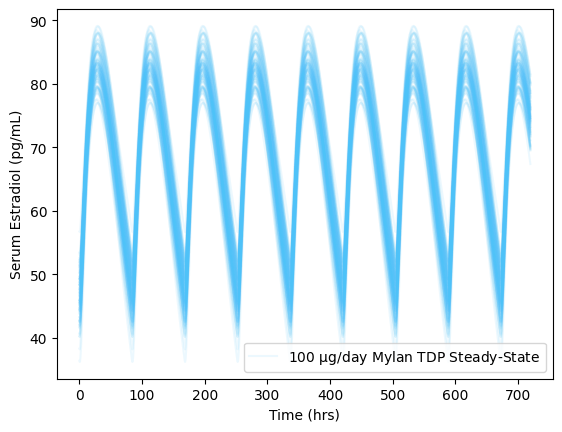

In [38]:
# steady-state solution

# smooth time interval
timeSS = np.arange(0,30*24,0.5)    # 30 days, in hrs

# sample from chain 1
inds = np.random.randint(len(sampleMylan100Removal["posterior"]["d0"][1]), size=100)

for ind in inds:
    sample = (sampleMylan100Removal["posterior"]["d0"][1].values.T[ind],
              sampleMylan100Removal["posterior"]["k1"][1].values.T[ind],
              sampleMylan100Removal["posterior"]["k2"][1].values.T[ind],
              sampleMylan100Removal["posterior"]["k3"][1].values.T[ind])
    plt.plot(timeSS, E2ss(timeSS, sample[0], sample[1], sample[2], sample[3], 3.5*24), alpha=0.1, color='#4EC2F8')
plt.plot(timeSS, E2ss(timeSS, sample[0], sample[1], sample[2], sample[3], 3.5*24), alpha=0.1, color='#4EC2F8', label='100 $\\rm\\mu g$/day Mylan TDP Steady-State')
#plt.plot(timeSS, Mylan100SS, label='100 $\\rm\\mu g$/day Mylan TDP Steady-State')
#plt.plot(MylanTDP100[:,0], result_emcee.best_fit, label='MCMC Best-Fit (MLE)', color='#F096AA', marker='o')
#plt.plot(timeSS, Mylan100SSMin, label='Minimum of 100 $\\rm\\mu g$/day Mylan TDP')
#plt.ylim(0,130)
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

The steady-state solution seems to be much higher than the fits when we didn't consider patch removal.

## Attempt 2

In [58]:
# patch removal
# instead of mp.math.switch, try heaviside, also outside of pm.Model()
# Heaviside only applies to D0, the time evolution of A_{\rm eff} and E_2 matters
def E2Patch(t, D0, k1, k2, k3, t_rem):
        AeffEvolutionBefore = D0 * k1 * (-np.exp(-k1 * t) + np.exp(-k2 * t)) / (k1 - k2)
        E2EvolutionBefore = E2DoseTerm(t, D0, k1, k2, k3) * np.exp(-k3 * t)
        AeffEvolutionAfter = D0 * k1 * (-np.exp(-k1 * (t-t_rem)) + np.exp(-k2 * (t-t_rem))) / (k1 - k2)
        E2EvolutionAfter = E2DoseTerm(t, D0, k1, k2, k3) * np.exp(-k3 * (t-t_rem))
        return E2Full(t, D0, AeffEvolutionBefore, E2EvolutionBefore, k1, k2, k3) * (1 - np.heaviside(t-t_rem, 0)) + E2Full(t, 0, AeffEvolutionAfter, E2EvolutionAfter, k1, k2, k3) * np.heaviside(t-t_rem, 0)

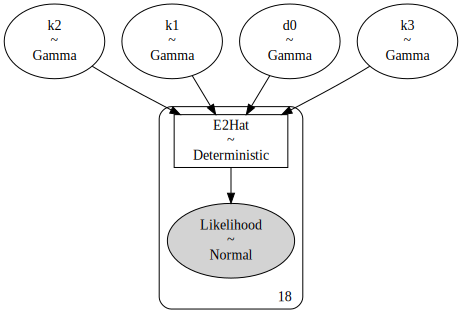

In [59]:
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/multilevel_modeling.ipynb
# the matrix exponential approach is really pretty and seamless for stitching different equations together and would work wonders in a multi-ROA/multi-model context... https://discord.com/channels/438306949285806082/1201973466845151362/1202269011497451540

with pm.Model() as Mylan100PatchRemoval2:
    # import data, https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.get_data.html
    # not doing this to avoid the need to write vectorized functions, https://discord.com/channels/438306949285806082/1201973466845151362/1209319299227983882
    #Mylan100TimeData = pm.ConstantData("Time", MylanTDP100[0:11,0], dims="obs")

    #Mylan100Data = pm.ConstantData("E2Observed", MylanTDP100[:,1], dims="obs_id")
    sigma = pm.math.sqrt(MylanTDP100[:,1])    # Standard deviation

    # set patch removal time, add 1 to avoid floating point error
    t_rem = MylanTDP100[0:11,0][10]+1

    ### priors on fitting parameters ###
    # need to fit d0
    d0 = pm.Gamma("d0", alpha=100, beta=0.5)    # https://www.geogebra.org/m/rz3vkzf5, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462

    # we shouldn't fit Aeff0 and E20, https://discord.com/channels/438306949285806082/1201973466845151362/1209294410731487255
    # rather depends on d0, k1, and k2

    # the initial conditions Aeff0 and E20 depend on k1, https://discord.com/channels/438306949285806082/1201973466845151362/1209306363440930927
    k1 = pm.Gamma("k1", alpha=1/(100/24), beta=4)    # https://www.desmos.com/calculator/vk2tqrxpk5
    k2 = pm.Gamma("k2", alpha=0.15, beta=4)    # based on previous fits
    k3 = pm.Gamma("k3", alpha=1/37, beta=4)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html
    ### end priors ###

    # initial conditions for after patch removal
    #AEffICAfter = pm.Deterministic("I.C. AEff(t_rem)", AEffAfterRemoval(MylanTDP100[:,0], d0, k1, k2))    # only need values after t_rem, using pm.math.switch below
    #E2ICAfter = pm.Deterministic("I.C. E2(t_rem)", E2AfterRemoval(MylanTDP100[:,0], d0, k1, k2, k3))

    # likelihood
    # switch: switch(t[i] < W, Normal(E2before(t[i]), sigma), Normal(E2after(t[i]), sigma)), https://discord.com/channels/438306949285806082/1201973466845151362/1209323159380168725
    E2Hat = pm.Deterministic("E2Hat", E2Patch(MylanTDP100[:,0], d0, k1, k2, k3, t_rem))

    Likelihood = pm.Normal("Likelihood", mu = E2Hat, observed = MylanTDP100[:,1],
                           sigma=sigma)

# visualize the model
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
pm.model_to_graphviz(Mylan100PatchRemoval)

In [60]:
# running HMC
with Mylan100PatchRemoval2:
    sampleMylan100Removal2 = pm.sample(15000, tune=1000)

az.summary(sampleMylan100Removal2, var_names = ["d0", "k1", "k2", "k3"], kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d0, k1, k2, k3]
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 60 seconds.


,mean,sd,hdi_3%,hdi_97%
d0,186.370,20.047,148.331,223.823
k1,0.231,0.050,0.143,0.328
k2,0.041,0.008,0.029,0.054
k3,0.036,0.005,0.027,0.045


In [61]:
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Mylan100PatchRemoval2:
    pm.sample_posterior_predictive(sampleMylan100Removal2, extend_inferencedata=True, random_seed=rng)

sampleMylan100Removal2

Sampling: [Likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [62]:
# extract predicted serum Estradiol, https://python.arviz.org/en/stable/api/generated/arviz.r2_score.html

Mylan100RemovalHat2 = sampleMylan100Removal2.posterior_predictive.stack(sample=("chain", "draw"))["Likelihood"].values.T

# obtain Maximum A-Posteriori, https://discord.com/channels/438306949285806082/1201973466845151362/1202106780339937310
# https://discourse.pymc.io/t/what-makes-difference-find-map-and-pm-sample/8182
with Mylan100PatchRemoval2:
    Mylan100RemovalMAP2 = pm.find_MAP()
Mylan100RemovalMAP2

{'d0_log__': array(5.22485207),
 'k1_log__': array(-1.49202102),
 'k2_log__': array(-3.22830398),
 'k3_log__': array(-3.32868416),
 'd0': array(185.8336788),
 'k1': array(0.22491763),
 'k2': array(0.03962465),
 'k3': array(0.03584023),
 'E2Hat': array([1.28094091e-27, 9.61984717e+00, 2.89964518e+01, 7.03198981e+01,
        9.54987527e+01, 1.12136449e+02, 9.52874590e+01, 7.48024707e+01,
        5.64205047e+01, 4.15840406e+01, 3.05396372e+01, 6.02313343e+00,
        1.17272181e+01, 1.48168514e+01, 1.34376751e+01, 9.91719110e+00,
        6.65606699e+00, 2.94999929e+00])}

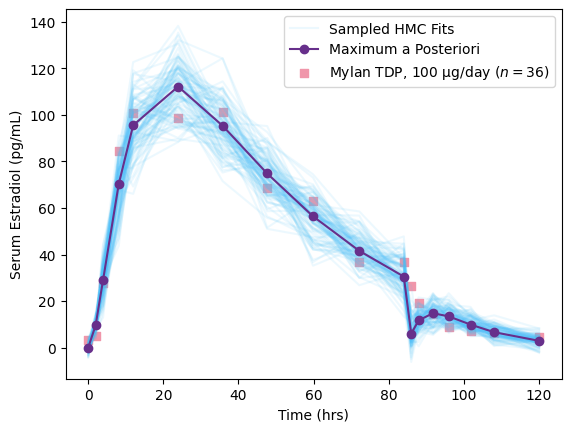

In [63]:
inds = np.random.randint(len(Mylan100RemovalHat2), size=100)

for ind in inds:
    plt.plot(MylanTDP100[:,0], Mylan100RemovalHat2[ind], alpha=0.1, color='#4EC2F8')
plt.plot(MylanTDP100[:,0], Mylan100RemovalHat2[50000], alpha=0.1, color='#4EC2F8', label='Sampled HMC Fits')
plt.plot(MylanTDP100[:,0], Mylan100RemovalMAP2['E2Hat'], label='Maximum a Posteriori', color='#672F8B', marker='o')
plt.scatter(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

## [Attempt 3](https://discord.com/channels/438306949285806082/1201973466845151362/1209725281124753558)... Thanks, Alix

In [89]:
def E2DoseTerm(t, d0, k1, k2, k3, es0=0.0, e20=0.0):
    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summationDose = d0 * k1 * k2 * (innerFunc1 - innerFunc2 + innerFunc3)
    if es0 > 0.0:
      summationDose += es0 * k2 / (k2 - k3) * (np.exp(-k3 * t) - np.exp(-k2 * t))
    if e20 > 0.0:
      summationDose += e20 * np.exp(-k3 * t)
    return summationDose

def Es(t, d0, k1, k2):
    return d0 * k1 / (k1 - k2) * (np.exp(-k2 * t) - np.exp(-k1 * t))

def E2Patch(t, d0, k1, k2, k3, W):
    if t < 0:
        return 0.0
    elif 0 <= t < W:
        return E2DoseTerm(t, d0, k1, k2, k3, es0=0.0, e20=0.0)
    elif t >= W:
        Es_at_W = Es(W, d0, k1, k2)
        E2_at_W = E2DoseTerm(W, d0, k1, k2, k3, es0=0.0, e20=0.0)
        return E2DoseTerm(t - W, 0.0, k1, k2, k3, es0=Es_at_W, e20=E2_at_W)

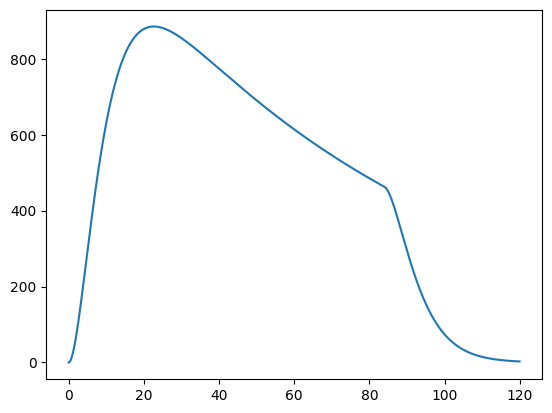

In [92]:
# divide the rates k1 k2 k3 by 24 if you want time in hours . https://discord.com/channels/438306949285806082/1201973466845151362/1209732871841914900
# k * t = (k / 24) * (24 * t)
timeSS_ = np.arange(0,5*24,0.1)
E2PatchOut = np.zeros(len(timeSS_))
for i in range(len(timeSS_)):
    E2PatchOut[i] = E2Patch(timeSS_[i], 16792, 0.283/24, 5.592/24, 4.3/24, 3.5*24)
plt.plot(timeSS_, E2PatchOut)